In [1]:
from simulation import citygraph_dataset
# from learning import inductive_route_learning, eval_route_generator, bee_colony
from learning.bee_colony import main as main_bee  # я так обозвал
from learning.eval_route_generator import main as main_eval # я так обозвал
from omegaconf import OmegaConf, DictConfig
from simulation import drawing

from tqdm import tqdm
from pathlib import Path

In [48]:
dataset = citygraph_dataset.DynamicCityGraphDataset(
    min_nodes=15,
    max_nodes=15,
    edge_keep_prob=0.7,
    data_type=citygraph_dataset.MIXED,  # or any other type you want
    directed=False,
    fully_connected_demand=True,  # default SIDE_LENGTH_M
    mumford_style=True,
    pos_only=False
)

# Generate graphs
n_graphs = 3  # number of graphs you want to generate
graphs = [dataset.generate_graph(draw=False) for _ in tqdm(range(n_graphs))]

100%|██████████| 3/3 [00:00<00:00, 115.41it/s]


In [49]:
import numpy as np

data_np = graphs[0]['street_adj'].numpy()
np.savetxt("MandlTrolleybusTravelTimes.txt", data_np, fmt="%.4f", delimiter=" ")


data_np = graphs[1]['street_adj'].numpy()
np.savetxt("MandlTrolleyTravelTimes.txt", data_np, fmt="%.4f", delimiter=" ")


data_np = graphs[2]['street_adj'].numpy()
np.savetxt("MandlBusTravelTimes.txt", data_np, fmt="%.4f", delimiter=" ")

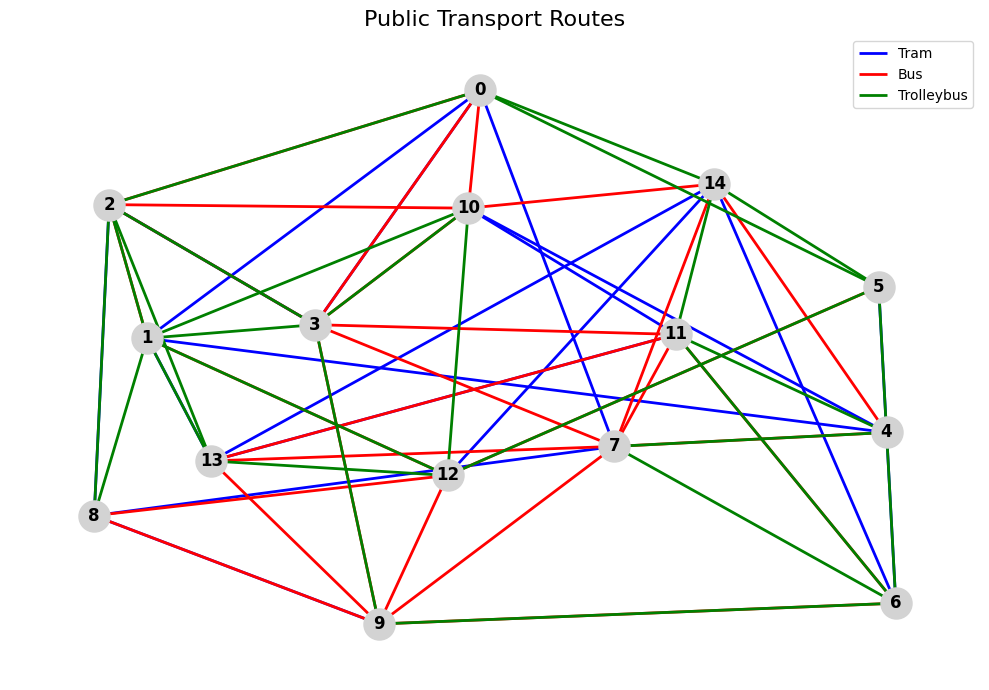

In [ ]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

tram = graphs[0]['street_adj']
bus = graphs[1]['street_adj']
trolleybus = graphs[2]['street_adj']

# ====== Функция для построения графа без inf ======
def matrix_to_graph(matrix):
    G = nx.Graph()
    n = matrix.shape[0]
    for i in range(n):
        for j in range(i+1, n):
            if matrix[i, j] != np.inf and matrix[i, j] != 0:
                G.add_edge(i, j, weight=matrix[i, j])
    return G

# ====== Построение всех графов ======
G_tram = matrix_to_graph(tram)
G_bus = matrix_to_graph(bus)
G_trolley = matrix_to_graph(trolleybus)

# ====== Общие координаты для всех ======
# Берём объединённый граф, чтобы layout совпадал
G_all = nx.compose_all([G_tram, G_bus, G_trolley])
pos = nx.spring_layout(G_all, seed=42)

# ====== Отрисовка в одной figure ======
plt.figure(figsize=(10, 7))

# Рисуем узлы (один раз)
nx.draw_networkx_nodes(G_all, pos, node_color="lightgray", node_size=500)
nx.draw_networkx_labels(G_all, pos, font_size=12, font_weight="bold")

# Рисуем рёбра каждого вида транспорта
nx.draw_networkx_edges(G_tram, pos, edge_color="blue", width=2, label="Tram")
nx.draw_networkx_edges(G_bus, pos, edge_color="red", width=2, label="Bus")
nx.draw_networkx_edges(G_trolley, pos, edge_color="green", width=2, label="Trolleybus")

# Оформление
plt.title("Public Transport Routes", fontsize=16)
plt.axis("off")
plt.legend()
plt.tight_layout()
plt.show()

In [21]:
import pickle
from pathlib import Path

# Путь для сохранения
save_path = Path('./output_graphs')
if not save_path.exists():
    save_path.mkdir(parents=True)

# Сохраняем объект в файл
with open(save_path / 'raw_graphs_1000.pkl', 'wb') as ff:
    pickle.dump(graphs, ff)


In [22]:
import pickle

with open(save_path / 'raw_graphs_1000.pkl', 'rb') as f:
    graphs = pickle.load(f)

In [23]:
from hydra import initialize_config_dir, compose
from omegaconf import OmegaConf
import os

cfg_dir = os.path.abspath("../TNDP_learning/cfg")

### Обучение LC

In [6]:
# with initialize_config_dir(config_dir=cfg_dir, job_name="app"):
#     cfg_learn = compose(config_name="ppo_20nodes_copy.yaml", # в этот файл можно положить путь к пикл файлу с графами, также можно попробовать другие параметры на обучение
#                             overrides=["+run_name=random_graphs"]) # при желании можно накинуть ему имя 


In [7]:
# print(OmegaConf.to_yaml(cfg_learn)) # чисто проверка как выглядит конфиг 

In [ ]:
# from learning import inductive_route_learning
# inductive_route_learning.setup_and_train(cfg_learn) # веса для модели вернутся в папку output, там будет файл .pt / при желании можно накинуть ему имя 

### Стартовый набор маршрутов

In [52]:
dataset_name = 'vo'
demand_time_weight = 0.33
route_time_weight = 0.33
median_connectivity_weight = 0.33
experiment_name = f'exp_{dataset_name}_pp_{demand_time_weight}_op_{route_time_weight}_cp_{median_connectivity_weight}'
initial_routes_name = experiment_name+ '_starting'
generated_routes_name = experiment_name + '_generated'

In [53]:
with initialize_config_dir(config_dir=cfg_dir, version_base=None):
    
    cfg_eval = compose(
        config_name="eval_model_mumford",   # из @hydra.main
        overrides=[
            f"+eval={dataset_name}", # конфиг в котором задается кол-во маршрутов и их макс и мин длины (можно заменить на vo для теста по ваське)
            "+model.weights=../TNDP_learning/output/inductive_random_graphs_checkpoints/iter990.pt", # путь к весам модели
            f"++run_name={initial_routes_name}", # имя запуска, вернет pickle файл с тензором в output_routes
            f"++experiment.cost_function.kwargs.demand_time_weight={demand_time_weight}",
            f"++experiment.cost_function.kwargs.route_time_weight={route_time_weight}",
            f"++experiment.cost_function.kwargs.median_connectivity_weight={median_connectivity_weight}"
        ]
    )

In [11]:
# print(OmegaConf.to_yaml(cfg_eval)) # чисто проверка как выглядит конфиг 

In [ ]:
metrics, unserved_demand = main_eval(cfg_eval)

In [51]:
unserved_demand

tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
      

In [27]:
unserved_demand

tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
      

### Генерация 

In [14]:
with initialize_config_dir(config_dir=cfg_dir, version_base=None):
    cfg_neural = compose(
        config_name="neural_bco_mumford",
        overrides=[
            f"+eval={dataset_name}", # конфиг в котором задается кол-во маршрутов и их макс и мин длины (можно заменить на vo для теста по ваське)
            "+model.weights=../TNDP_learning/output/inductive_random_graphs_checkpoints/iter990.pt", # путь к весам модели
            f"++run_name={generated_routes_name}", # имя запуска, вернет pickle файл с тензором в output_routes
            f"++experiment.cost_function.kwargs.demand_time_weight={demand_time_weight}",
            f"++experiment.cost_function.kwargs.route_time_weight={route_time_weight}",
            f"++experiment.cost_function.kwargs.median_connectivity_weight={median_connectivity_weight}",
            f"init.path=output_routes/nn_construction_{initial_routes_name}_routes.pkl",
        ]
    )

In [15]:
# print(OmegaConf.to_yaml(cfg_neural)) # чисто проверка как выглядит конфиг 

In [16]:
metrics, unserved_demand = main_bee(cfg_neural)

In [ ]:
metrics['median_connectivity'] /= 60 

In [ ]:
# Порядок нужных ключей
keys_order = ['ATT', 'RTT', 'median_connectivity', 'cost', '$d_{un}$', '$d_0$', '$d_1$', '$d_2$']

print('\t'.join(str(round(metrics[key].item(),3)) for key in keys_order))
print('\t'.join(str(round(metrics[key].item(),3)) for key in keys_order))

10.954	244.0	12.0	0.332	0.0	84.393	13.166	2.441
10.954	244.0	12.0	0.332	0.0	84.393	13.166	2.441


In [ ]:
import csv
from pathlib import Path
from hydra import initialize_config_dir, compose
from omegaconf import OmegaConf
from learning.eval_route_generator import main as main_eval
from learning.bee_colony import main as main_bee
from tqdm import tqdm

# Путь к конфигам
cfg_dir = Path("../TNDP_learning/cfg").resolve()

# Все параметры экспериментов
experiments = [
    ("mandl", 1, 0, 0),
    ("mandl", 0, 1, 0),
    ("mandl", 0, 0, 1),
    ("mandl", 0.5, 0.5, 0),
    ("mandl", 0.5, 0, 0.5),
    ("mandl", 0, 0.5, 0.5),
    ("mandl", 0.33, 0.33, 0.33),
    ("mumford0", 1, 0, 0),
    ("mumford0", 0, 1, 0),
    ("mumford0", 0, 0, 1),
    ("mumford0", 0.5, 0.5, 0),
    ("mumford0", 0.5, 0, 0.5),
    ("mumford0", 0, 0.5, 0.5),
    ("mumford0", 0.33, 0.33, 0.33),
    ("mumford1", 1, 0, 0),
    ("mumford1", 0, 1, 0),
    ("mumford1", 0, 0, 1),
    ("mumford1", 0.5, 0.5, 0),
    ("mumford1", 0.5, 0, 0.5),
    ("mumford1", 0, 0.5, 0.5),
    ("mumford1", 0.33, 0.33, 0.33),
    ("mumford2", 1, 0, 0),
    ("mumford2", 0, 1, 0),
    ("mumford2", 0, 0, 1),
    ("mumford2", 0.5, 0.5, 0),
    ("mumford2", 0.5, 0, 0.5),
    ("mumford2", 0, 0.5, 0.5),
    ("mumford2", 0.33, 0.33, 0.33),
    ("mumford3", 1, 0, 0),
    ("mumford3", 0, 1, 0),
    ("mumford3", 0, 0, 1),
    ("mumford3", 0.5, 0.5, 0),
    ("mumford3", 0.5, 0, 0.5),
    ("mumford3", 0, 0.5, 0.5),
    ("mumford3", 0.33, 0.33, 0.33),
]

# Путь к весам модели
model_weights_path = "../TNDP_learning/output/inductive_random_graphs_checkpoints/iter990.pt"

# CSV файл для результатов
results_file = Path("experiment_results.csv")
if not results_file.exists():
    with open(results_file, mode='w', newline='') as f:
        writer = csv.writer(f)
        writer.writerow([
            "dataset", "demand_time", "route_time", "connectivity",
            "ATT", "RTT", "median_connectivity", "cost", "$d_{un}$", "$d_0$", "$d_1$", "$d_2$"
        ])

# Запуск экспериментов с tqdm
for dataset_name, dt, rt, ct in tqdm(experiments, desc="Running experiments"):
    try:
        experiment_name = f"exp_{dataset_name}_pp_{dt}_op_{rt}_cp_{ct}"
        initial_routes_name = experiment_name + '_starting'
        generated_routes_name = experiment_name + '_generated'

        with initialize_config_dir(config_dir=str(cfg_dir), version_base=None):
            cfg_eval = compose(
                config_name="eval_model_mumford",
                overrides=[
                    f"+eval={dataset_name.lower()}",
                    f"+model.weights={model_weights_path}",
                    f"++run_name={initial_routes_name}",
                    f"++experiment.cost_function.kwargs.demand_time_weight={dt}",
                    f"++experiment.cost_function.kwargs.route_time_weight={rt}",
                    f"++experiment.cost_function.kwargs.median_connectivity_weight={ct}"
                ]
            )
        eval_metrics, unserved_demand = main_eval(cfg_eval)

        with initialize_config_dir(config_dir=str(cfg_dir), version_base=None):
            cfg_bee = compose(
                config_name="neural_bco_mumford",
                overrides=[
                    f"+eval={dataset_name.lower()}",
                    f"+model.weights={model_weights_path}",
                    f"++run_name={generated_routes_name}",
                    f"++experiment.cost_function.kwargs.demand_time_weight={dt}",
                    f"++experiment.cost_function.kwargs.route_time_weight={rt}",
                    f"++experiment.cost_function.kwargs.median_connectivity_weight={ct}",
                    f"init.path=output_routes/nn_construction_{initial_routes_name}_routes.pkl",
                ]
            )
        bee_metrics, unserved_demand = main_bee(cfg_bee)
        bee_metrics['median_connectivity'] /= 60

        keys_order = ['ATT', 'RTT', 'median_connectivity', 'cost', '$d_{un}$', '$d_0$', '$d_1$', '$d_2$']
        row = [dataset_name.lower(), dt, rt, ct] + [round(bee_metrics[k].item(), 4) for k in keys_order]

        with open(results_file, mode='a', newline='') as f:
            csv.writer(f).writerow(row)

    except Exception as e:
        print(f"[✗] Failed {experiment_name}: {e}")

Running experiments:   0%|          | 0/35 [00:00<?, ?it/s]

/root/TNDP_learning/learning/utils.py:320: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at /pytorch/aten/src/ATen/native/ReduceOps.cpp:1831.)
  out_stats = (final_costs.mean(), final_costs.std(), metrics)
Running experiments:  57%|█████▋    | 20/35 [16:15:46<12:11:49, 2927.32s/it]


KeyboardInterrupt: 

In [ ]:
# Эксперименты только с mandl
import csv
from pathlib import Path
from hydra import initialize_config_dir, compose
from learning.eval_route_generator import main as main_eval
from tqdm import tqdm

model_weights_path = "../TNDP_learning/output/inductive_random_graphs_checkpoints/iter990.pt"

mandl_experiments = [
    ("mandl", 1, 0, 0),
    ("mandl", 0, 1, 0),
    ("mandl", 0, 0, 1),
    ("mandl", 0.5, 0.5, 0),
    ("mandl", 0.5, 0, 0.5),
    ("mandl", 0, 0.5, 0.5),
    ("mandl", 0.33, 0.33, 0.33),
]

# CSV файл
results_file = Path("eval_only_mandl.csv")
if not results_file.exists():
    with open(results_file, mode='w', newline='') as f:
        csv.writer(f).writerow([
            "dataset", "demand_time", "route_time", "connectivity",
            "ATT", "RTT", "median_connectivity", "cost", "$d_{un}$", "$d_0$", "$d_1$", "$d_2$"
        ])

# Запуск экспериментов только main_eval
for dataset_name, dt, rt, ct in tqdm(mandl_experiments, desc="Evaluating mandl"):
    try:
        run_name = f"mandl_eval_pp_{dt}_op_{rt}_cp_{ct}"

        with initialize_config_dir(config_dir=str(cfg_dir), version_base=None):
            cfg_eval = compose(
                config_name="eval_model_mumford",
                overrides=[
                    f"+eval={dataset_name}",
                    f"+model.weights={model_weights_path}",
                    f"++run_name={run_name}",
                    f"++experiment.cost_function.kwargs.demand_time_weight={dt}",
                    f"++experiment.cost_function.kwargs.route_time_weight={rt}",
                    f"++experiment.cost_function.kwargs.median_connectivity_weight={ct}",
                ]
            )

        metrics = main_eval(cfg_eval)
        keys_order = ['ATT', 'RTT', 'median_connectivity', 'cost', '$d_{un}$', '$d_0$', '$d_1$', '$d_2$']
        row = [dataset_name, dt, rt, ct] + [round(metrics[k].item(), 4) for k in keys_order]

        with open(results_file, mode='a', newline='') as f:
            csv.writer(f).writerow(row)

    except Exception as e:
        print(f"[✗] Failed eval for {run_name}: {e}")

Evaluating mandl:   0%|          | 0/7 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.63s/it]
/root/TNDP_learning/learning/utils.py:320: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at /pytorch/aten/src/ATen/native/ReduceOps.cpp:1831.)
  out_stats = (final_costs.mean(), final_costs.std(), metrics)
Evaluating mandl:  14%|█▍        | 1/7 [00:01<00:11,  1.87s/it]

,6.000,0.332,10.954,244.000,84.393,13.166,2.441,0.000,0.000,0.000,720.000,1.621,0.000
{'cost': tensor([0.3319]), 'ATT': tensor([10.9538]), 'RTT': tensor([244.]), '$d_0$': tensor([84.3931]), '$d_1$': tensor([13.1663]), '$d_2$': tensor([2.4406]), '$d_{un}$': tensor([0.]), '# disconnected node pairs': tensor([0.]), '# stops out of bounds': tensor([0.]), 'median_connectivity': tensor([720.]), 'average wall-clock duration': tensor([1.6207]), 'average # iterations': tensor([0.])}


100%|██████████| 1/1 [00:00<00:00, -1.44it/s]


,6.000,0.747,13.493,148.000,59.216,36.609,4.110,0.064,0.000,0.000,868.000,-0.701,0.000
{'cost': tensor([0.7475]), 'ATT': tensor([13.4926]), 'RTT': tensor([148.]), '$d_0$': tensor([59.2164]), '$d_1$': tensor([36.6089]), '$d_2$': tensor([4.1105]), '$d_{un}$': tensor([0.0642]), '# disconnected node pairs': tensor([0.]), '# stops out of bounds': tensor([0.]), 'median_connectivity': tensor([868.]), 'average wall-clock duration': tensor([-0.7006]), 'average # iterations': tensor([0.])}


Evaluating mandl:  43%|████▎     | 3/7 [00:02<00:03,  1.11it/s]

,6.000,0.362,11.101,240.000,79.833,19.075,1.092,0.000,0.000,0.000,716.000,1.597,0.000
{'cost': tensor([0.3616]), 'ATT': tensor([11.1015]), 'RTT': tensor([240.]), '$d_0$': tensor([79.8330]), '$d_1$': tensor([19.0751]), '$d_2$': tensor([1.0918]), '$d_{un}$': tensor([0.]), '# disconnected node pairs': tensor([0.]), '# stops out of bounds': tensor([0.]), 'median_connectivity': tensor([716.]), 'average wall-clock duration': tensor([1.5975]), 'average # iterations': tensor([0.])}


Evaluating mandl:  57%|█████▋    | 4/7 [00:04<00:03,  1.18s/it]

,6.000,0.585,13.248,152.000,59.409,39.435,1.156,0.000,0.000,0.000,816.000,1.600,0.000
{'cost': tensor([0.5846]), 'ATT': tensor([13.2479]), 'RTT': tensor([152.]), '$d_0$': tensor([59.4091]), '$d_1$': tensor([39.4348]), '$d_2$': tensor([1.1561]), '$d_{un}$': tensor([0.]), '# disconnected node pairs': tensor([0.]), '# stops out of bounds': tensor([0.]), 'median_connectivity': tensor([816.]), 'average wall-clock duration': tensor([1.6001]), 'average # iterations': tensor([0.])}


Evaluating mandl:  71%|███████▏  | 5/7 [00:06<00:02,  1.35s/it]

,6.000,0.348,10.954,244.000,84.393,13.166,2.441,0.000,0.000,0.000,720.000,1.601,0.000
{'cost': tensor([0.3478]), 'ATT': tensor([10.9538]), 'RTT': tensor([244.]), '$d_0$': tensor([84.3931]), '$d_1$': tensor([13.1663]), '$d_2$': tensor([2.4406]), '$d_{un}$': tensor([0.]), '# disconnected node pairs': tensor([0.]), '# stops out of bounds': tensor([0.]), 'median_connectivity': tensor([720.]), 'average wall-clock duration': tensor([1.6012]), 'average # iterations': tensor([0.])}


Evaluating mandl:  86%|████████▌ | 6/7 [00:08<00:01,  1.47s/it]

,6.000,0.590,13.248,152.000,59.409,39.435,1.156,0.000,0.000,0.000,816.000,1.597,0.000
{'cost': tensor([0.5899]), 'ATT': tensor([13.2479]), 'RTT': tensor([152.]), '$d_0$': tensor([59.4091]), '$d_1$': tensor([39.4348]), '$d_2$': tensor([1.1561]), '$d_{un}$': tensor([0.]), '# disconnected node pairs': tensor([0.]), '# stops out of bounds': tensor([0.]), 'median_connectivity': tensor([816.]), 'average wall-clock duration': tensor([1.5967]), 'average # iterations': tensor([0.])}


Evaluating mandl: 100%|██████████| 7/7 [00:09<00:00,  1.41s/it]

,6.000,0.524,12.087,164.000,69.043,28.003,2.954,0.000,0.000,0.000,780.000,1.620,0.000
{'cost': tensor([0.5242]), 'ATT': tensor([12.0873]), 'RTT': tensor([164.]), '$d_0$': tensor([69.0430]), '$d_1$': tensor([28.0026]), '$d_2$': tensor([2.9544]), '$d_{un}$': tensor([0.]), '# disconnected node pairs': tensor([0.]), '# stops out of bounds': tensor([0.]), 'median_connectivity': tensor([780.]), 'average wall-clock duration': tensor([1.6195]), 'average # iterations': tensor([0.])}
